In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from matplotlib.patches import Ellipse
from scipy import linalg
from sklearn.decomposition import PCA

import utils

In [2]:
sustain_w_regions = pd.read_csv("../data/sustainability_w_regions.csv")
sustain_w_regions = sustain_w_regions.drop(
    columns=[
        "country-code",
        "World Regions (UN SDG Definition)",
        "Continent",
        "region",
        "region-code",
        "iso_3166-2",
        "name",
        "alpha-2",
        "sub-region",
        "intermediate-region",
        "sub-region-code",
        "intermediate-region-code",
        "Income Classification (World Bank Definition)"
    ]
)
# Rename features with shorter names so the labels aren't
# too long for the visualizations
rename = dict(zip(list(sustain_w_regions.columns), utils.feature_short_names))

df = sustain_w_regions.rename(rename, axis=1)

# Save name mapping
pickle.dump(rename, open("rename_mapping.pickle", "wb"))

### Data Cleaning - Deal with Null Values
- Automatically drop any column with more than 50% nulls.
- Interpolate values using backwards fill for nulls, ensure df is sorted by country and year first. Forward fill in any remaining cases that backwards fill can't (e.g. 2018 - the last year in the dataset)
- Also drop Income Classification variable automatically because we will have to encode it, but other variables like GDP per Capita cover this measure, so we can just drop it.

Note: Nulls are read in/recorded as 0s in many cases

In [3]:
for column in df.columns:
    pct_null = len(df[(df[column] == 0) | df[column].isnull()]) / len(df)
    if pct_null > 0.5:
        print(f"{column} has {pct_null} proportion null")

Net Forest Depletion (% GNI) has 0.6811682385153636 proportion null
Below Internatl. Poverty Line (%) has 0.6568299361119562 proportion null
Population Covered by 3G+ Network (%) has 0.6105871615454822 proportion null
Gini Index has 0.6035898996045026 proportion null


In [4]:
df = df.drop(
    columns=[
        "Net Forest Depletion (% GNI)",
        "Below Internatl. Poverty Line (%)",
        "Population Covered by 3G+ Network (%)",
        "Gini Index",
    ]
)

Interpolate

In [5]:
df = df.sort_values(by=["Name", "Year"]).groupby("Name").bfill().ffill()

We need to convert "Regime Type" into integers representing each discrete option- e.g. an encoding.

In [6]:
encoding = pd.Series(pd.factorize(df["Regime Type"])[0], index=df.index)
encoding.name = "encoding"

df = df.merge(encoding, left_index=True, right_index=True, how="inner").drop(
    columns='Regime Type'
).rename(
    columns={'encoding': 'Regime Type'}
)

For PCA, only taking one entry for each country (the last year in the data, for instance) appears to be the best approach.

This also makes sense since we plan on clustering the countries, not doing a time-series model at first.

In [7]:
df = df.drop_duplicates(subset=['Alpha-2'], keep='last')

Drop metadata columns - no longer needed; **however WE MUST ensure that when we merge them back, we sort by name and year first so the indices align.**

In [8]:
# Name is already gone due to the groupby
df = df.drop(columns=["Alpha-2", "Year"])

### PCA Without Dropping Highly Correlated Features

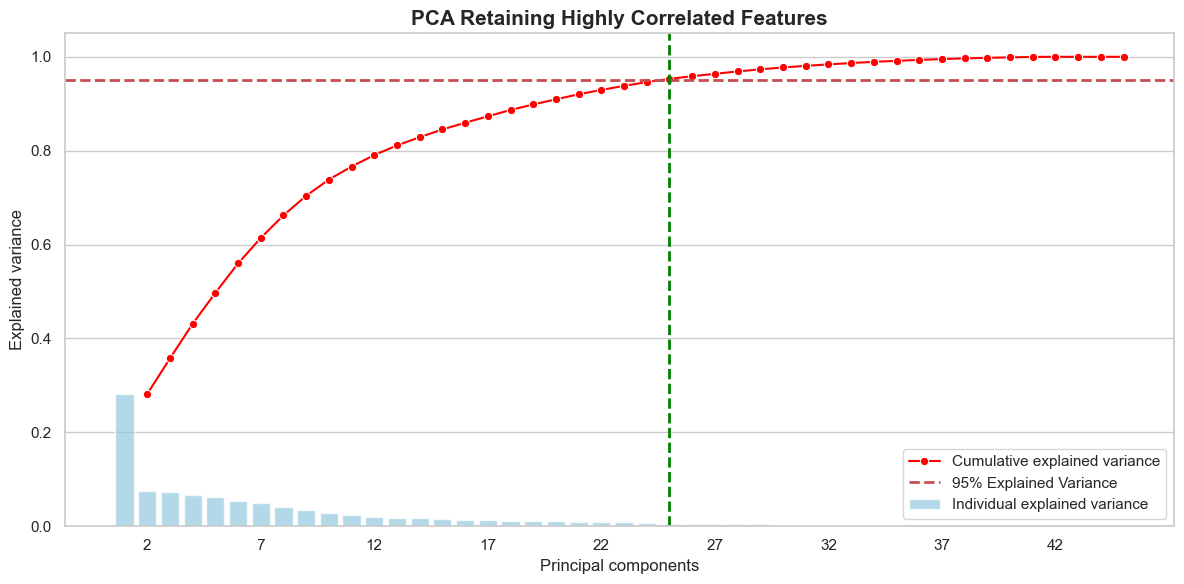

In [9]:
pca, pca_df = utils.create_pca(df)
init_pca_viz = utils.viz_pca(pca, "Retaining Highly Correlated Features")
init_pca_viz.show()

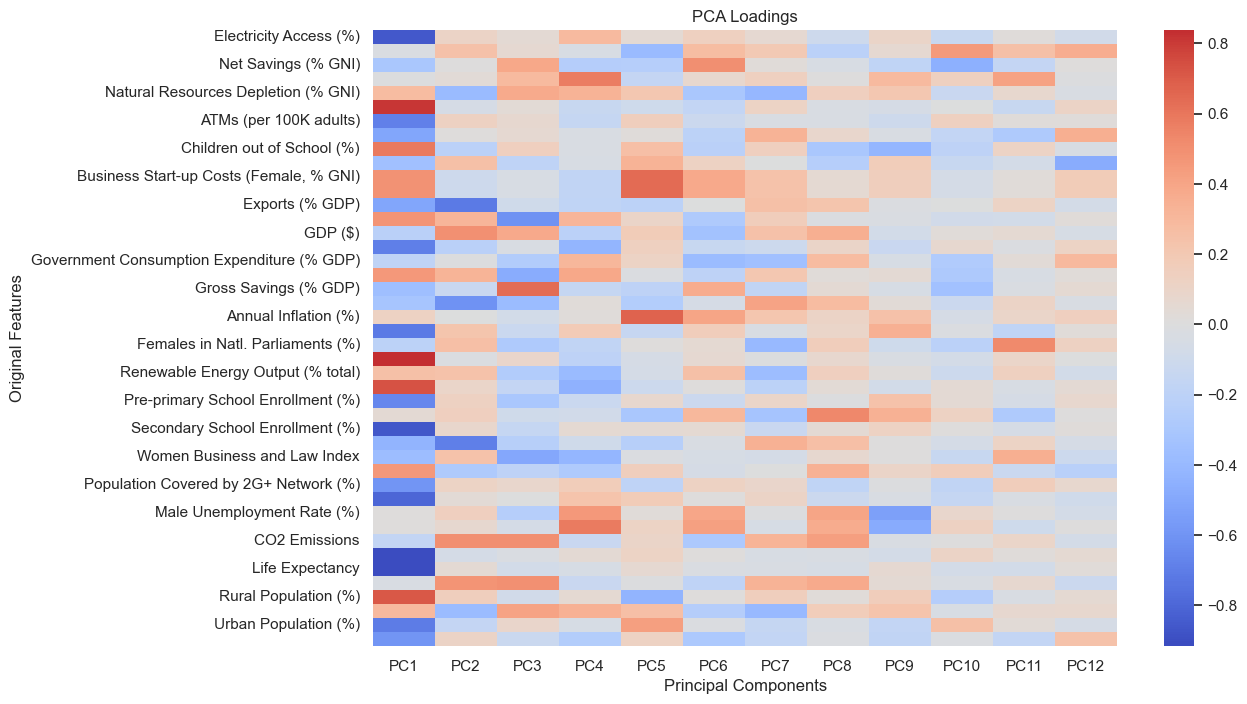

In [10]:
num_components = 12
init_pca_n, init_pca_df_n, init_pca_heatmap = utils.viz_pca_heatmap(df, 12)
init_pca_heatmap.show()

In [11]:
init_loadings = utils.create_loadings(df, init_pca_n)
utils.print_top_features_for_component(init_pca_n, init_loadings, 5)

PC1 top 5 features and explained variance:
Population Using Internet (%): 0.8389
Life Expectancy: 0.8347
Secondary School Enrollment (%): 0.7475
Electricity Access (%): 0.7374
Pupil-teacher Ratio: 0.7019

PC2 top 5 features and explained variance:
Exports (% GDP): 0.5082
Trade (% GDP): 0.4783
Imports (% GDP): 0.3755
CO2 Emissions: 0.2562
GDP ($): 0.2428

PC3 top 5 features and explained variance:
Gross Savings (% GDP): 0.4067
Consumption Expenditure (% GDP): 0.3744
CO2 Emissions: 0.2535
Women Business and Law Index: 0.2532
Total Population: 0.2428

PC4 top 5 features and explained variance:
Female Unemployment Rate (%): 0.3353
Carbon Dioxide Damage (% GNI): 0.3323
Male Unemployment Rate (%): 0.2095
Renewable Energy Consumption (% total): 0.2026
GDP per Capita ($): 0.1790

PC5 top 5 features and explained variance:
Annual Inflation (%): 0.4535
Business Start-up Costs (Male, % GNI): 0.4141
Business Start-up Costs (Female, % GNI): 0.4140
Urban Population (%): 0.1866
Rural Population (%): 

### Feature Selection and Engineering (Dealing with Highly Correlated Features)

In [12]:
init_corr = df.corr()

/var/folders/j0/5yfrsf617z7b5_lkbnsqzmh80000gn/T/ipykernel_65491/2318300724.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  init_corr_viz.show()


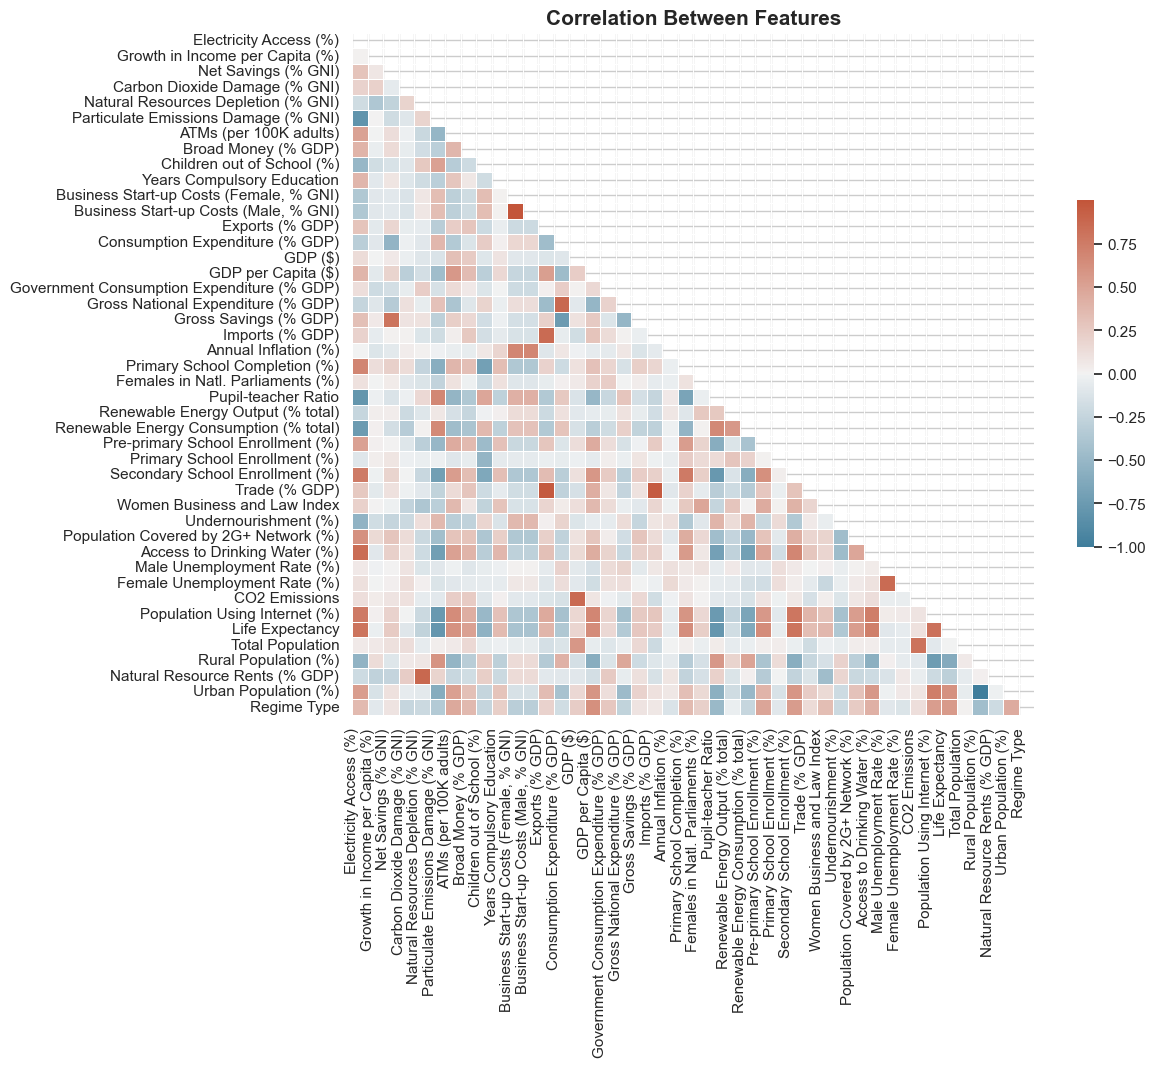

In [13]:
init_corr_viz = utils.viz_corr_heatmap(init_corr, False)
init_corr_viz.show()

/var/folders/j0/5yfrsf617z7b5_lkbnsqzmh80000gn/T/ipykernel_65491/3679950773.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  init_corr_abs_viz.show()


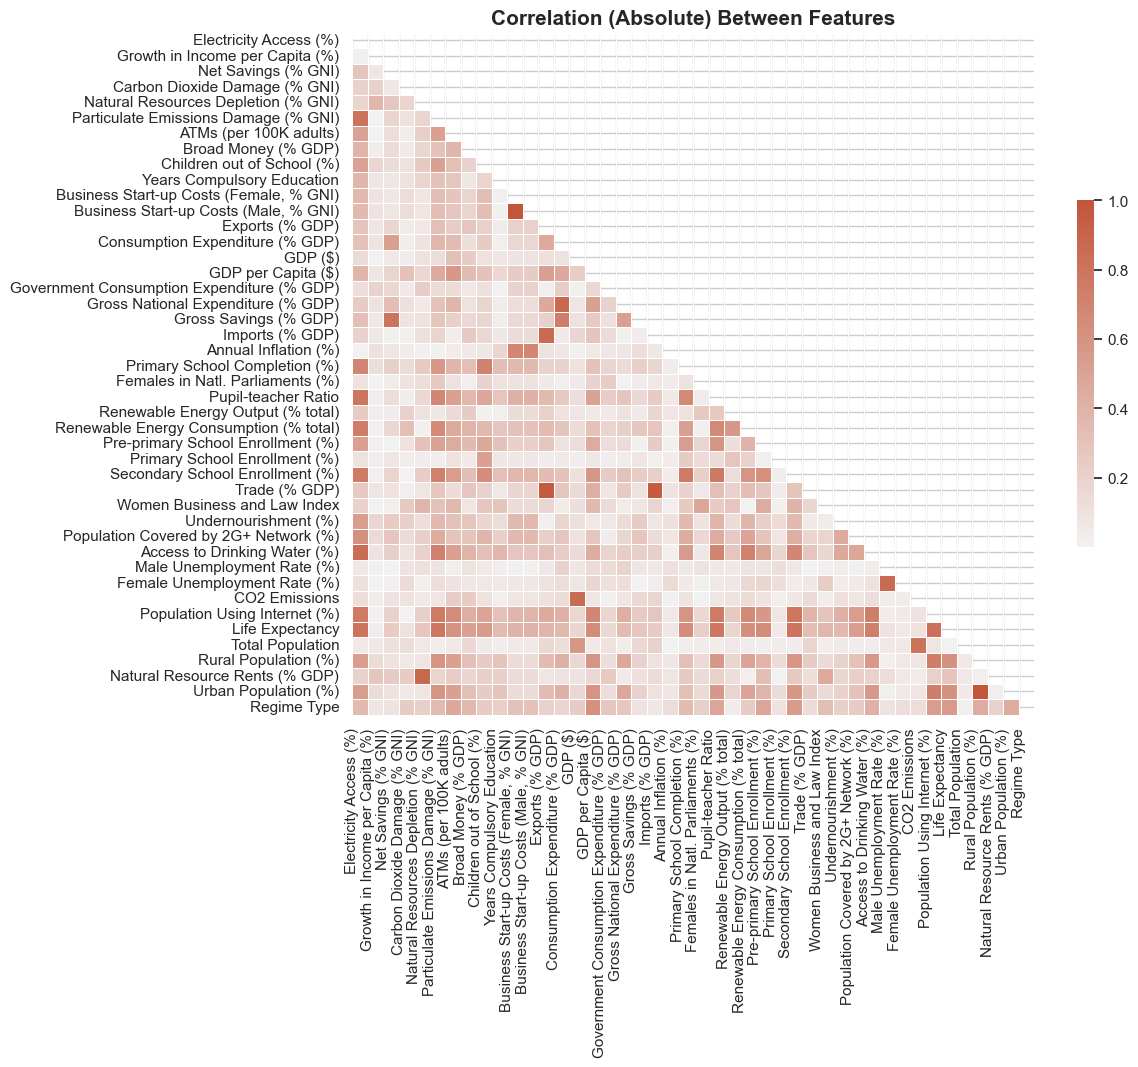

In [14]:
init_corr_abs_viz = utils.viz_corr_heatmap(init_corr.abs(), True)
init_corr_abs_viz.show()

Eliminate highly correlated features. We will output each feature, followed by any features that have a correlation of over 0.6 with the given feature. Using this information, we will decide if we'd like to retain both features or only keep one.

In [15]:
for series_name, series in init_corr.abs().items():
    high_corr = series[(series > 0.6) & (series != 1)]
    if not high_corr.empty:
        print(series_name + " ------")
        print(high_corr)
        print("")

Electricity Access (%) ------
Particulate Emissions Damage (% GNI)      0.806976
Primary School Completion (%)             0.693028
Pupil-teacher Ratio                       0.794421
Renewable Energy Consumption (% total)    0.743342
Secondary School Enrollment (%)           0.756570
Population Covered by 2G+ Network (%)     0.609961
Access to Drinking Water (%)              0.850980
Population Using Internet (%)             0.764076
Life Expectancy                           0.799997
Name: Electricity Access (%), dtype: float64

Net Savings (% GNI) ------
Gross Savings (% GDP)    0.801832
Name: Net Savings (% GNI), dtype: float64

Natural Resources Depletion (% GNI) ------
Natural Resource Rents (% GDP)    0.877162
Name: Natural Resources Depletion (% GNI), dtype: float64

Particulate Emissions Damage (% GNI) ------
Electricity Access (%)                    0.806976
Pupil-teacher Ratio                       0.672545
Renewable Energy Consumption (% total)    0.659849
Secondary School En

From these findings, we make the following decisions:
- Keep Natural Resources Rents, but drop Natural Resource Depletion; we do not believe there is much additional value in keeping both, and rents captures more information due to its economic implications.
- Drop Business Start-up Costs Male and keep Business Start-up Costs Female; these appear to be identical features.
- Drop Gross National Expenditure and keep Consumption Expenditure; both are very similar, but we prefer looking consumption specifically  due to its environmental concerns.
- Drop Coverage by 2G and 3G Networks but keep Internet Usage; we feel actual ability to use of internet easily (say, through a library or other public service) is more important than potentially expensive 2G or 3G services.
- Drop Urban Population but keep Rural Population; these features are very similar but Urban Population was more correlated with other features, so we choose to keep Rural Population.

Feature Engineering:
- Drop exports, imports, and trade (all highly correlated). Instead, make a trade deficit variable (exports - imports).
- Drop CO2 Emissions and create a CO2 Emissions per Capita measure. The current measure are raw emissions, so it is correlated with total population. We don't think CO2 Emissions alone is a useful feature, per Capita is much more informative.

In [16]:
df_uncorr = df.copy()

# Feature Engineering
df_uncorr["Trade Deficit (% GDP)"] = (
    df_uncorr["Exports (% GDP)"] - df_uncorr["Imports (% GDP)"]
)

# CO2 Emissions were Measured in Million Tonnes
df_uncorr["CO2 Emissions per Capita"] = (
    df_uncorr["CO2 Emissions"] * 1000000 / df_uncorr["Total Population"]
)

# Feature Selection
df_uncorr = df_uncorr.drop(
    columns=[
        "Exports (% GDP)",
        "Imports (% GDP)",
        "Trade (% GDP)",
        "CO2 Emissions",
        "Natural Resources Depletion (% GNI)",
        "Business Start-up Costs (Male, % GNI)",
        "Gross National Expenditure (% GDP)",
        "Urban Population (%)"
    ]
)

In [17]:
dropped_corr = df_uncorr.corr()

/var/folders/j0/5yfrsf617z7b5_lkbnsqzmh80000gn/T/ipykernel_65491/3842463103.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  init_dropped_corr_viz.show()


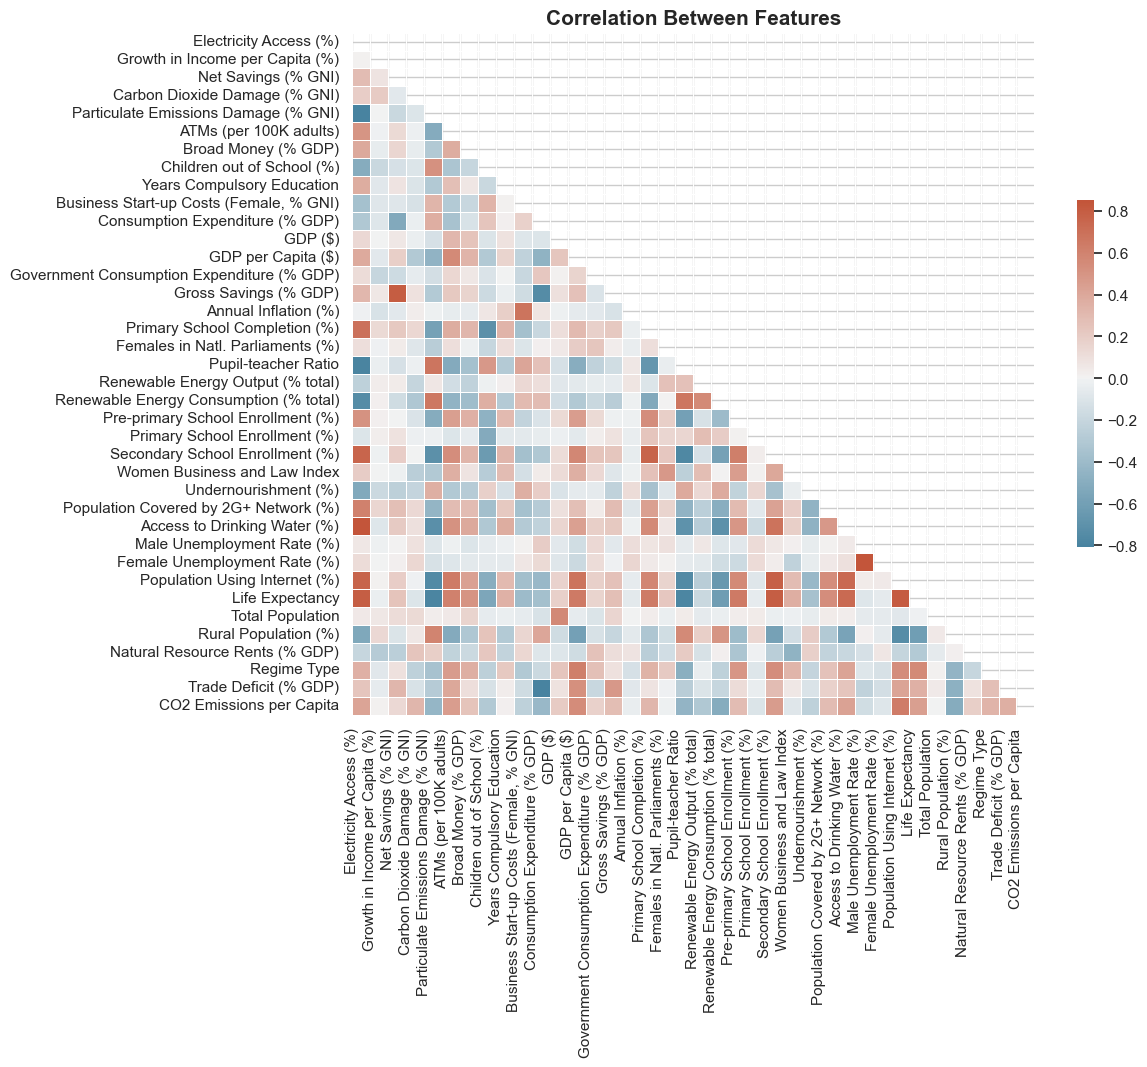

In [18]:
init_dropped_corr_viz = utils.viz_corr_heatmap(dropped_corr, False)
init_dropped_corr_viz.show()

/var/folders/j0/5yfrsf617z7b5_lkbnsqzmh80000gn/T/ipykernel_65491/596462957.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  init_dropped_corr_abs_viz.show()


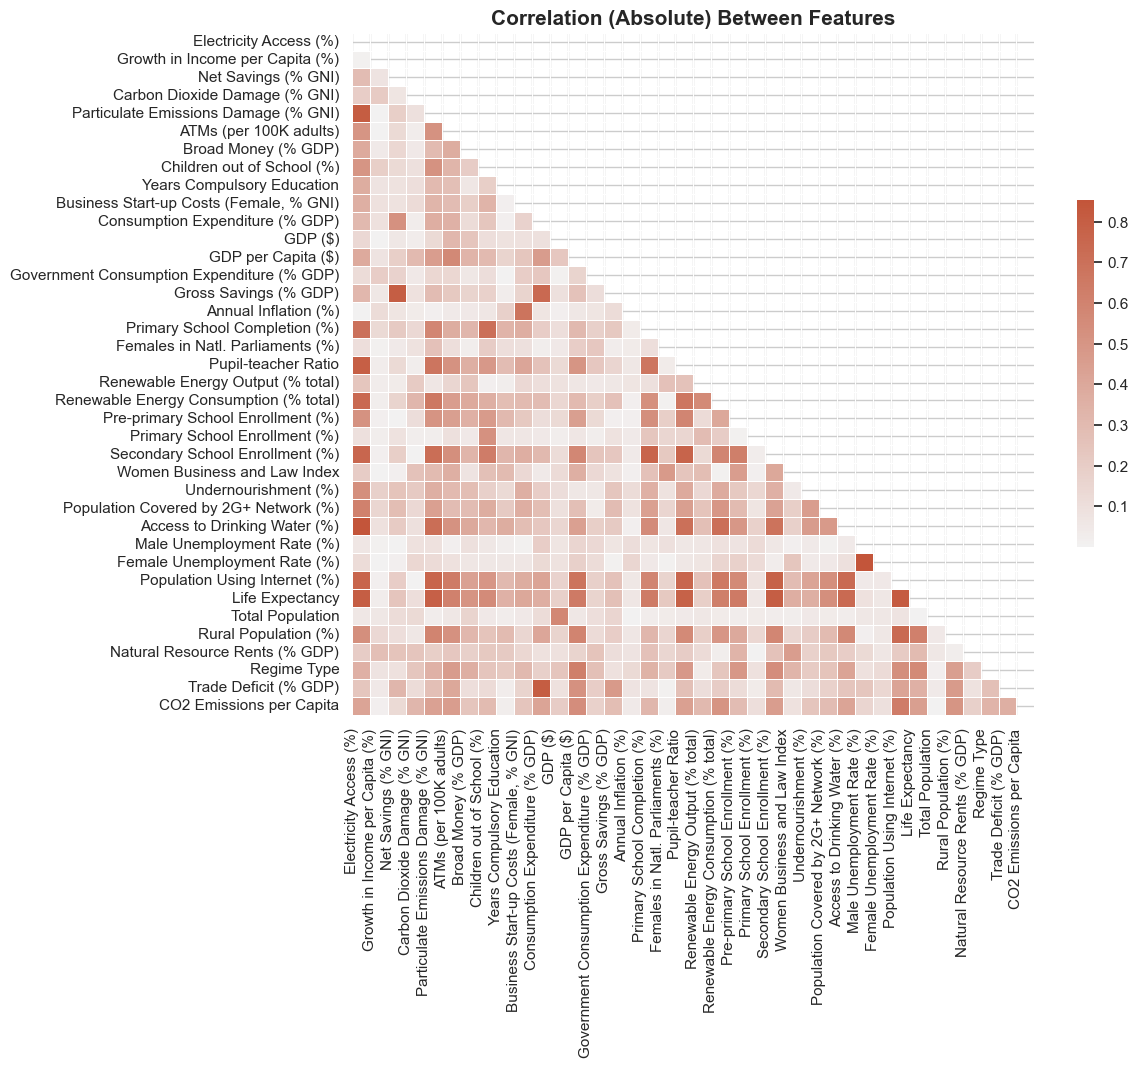

In [19]:
init_dropped_corr_abs_viz = utils.viz_corr_heatmap(dropped_corr.abs(), True)
init_dropped_corr_abs_viz.show()

### PCA after Feature Engineering

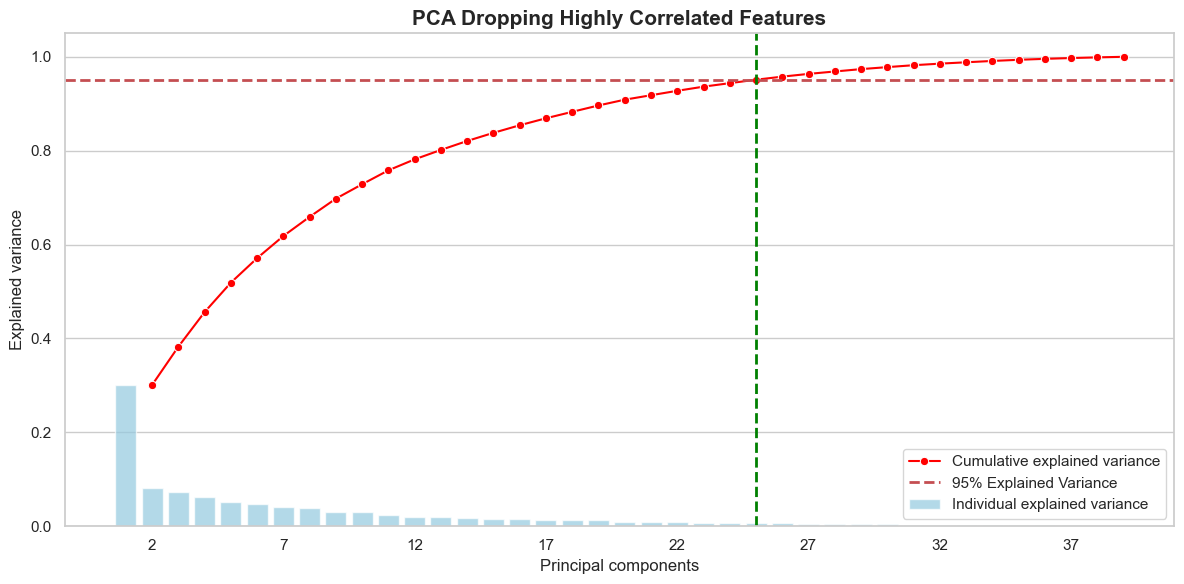

In [20]:
final_pca, final_pca_df = utils.create_pca(df_uncorr)
final_pca_viz = utils.viz_pca(final_pca, "Dropping Highly Correlated Features")
final_pca_viz.show()

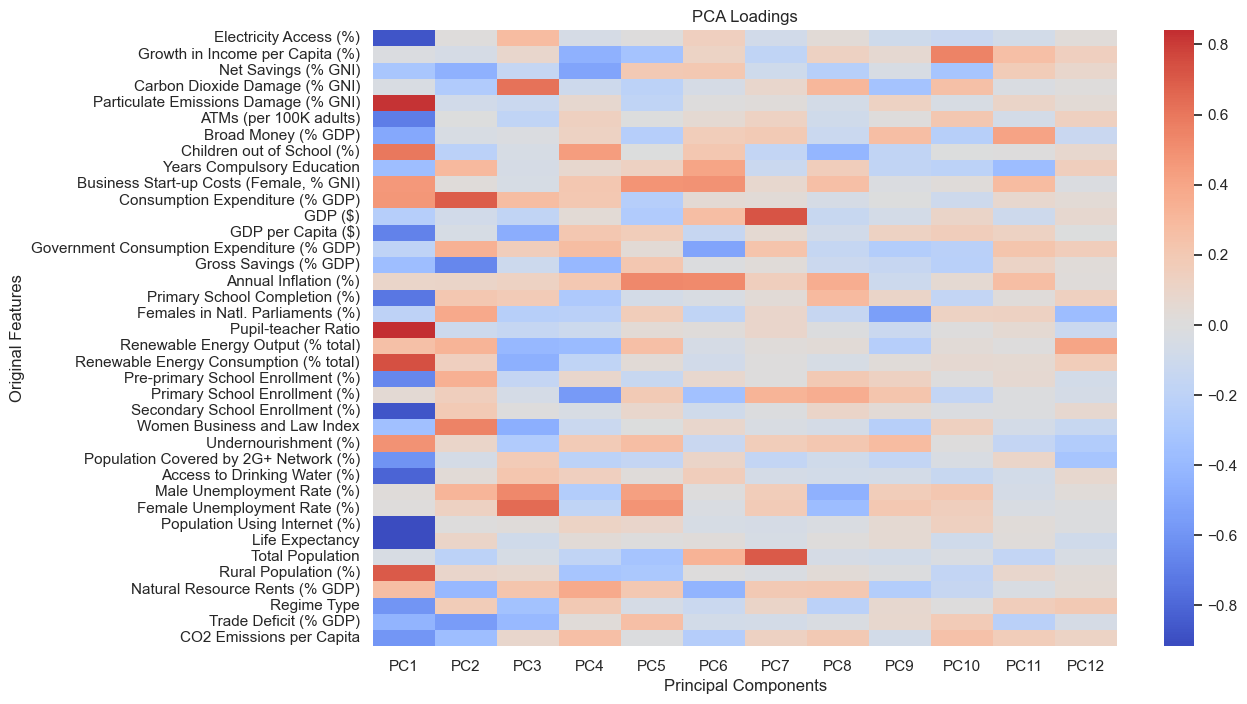

In [21]:
num_components = 12
final_pca_n, final_pca_n_df, final_pca_heatmap = utils.viz_pca_heatmap(df_uncorr, 12)
final_pca_heatmap.show()

In [22]:
final_pca_n_df.columns = [f"PCA{i+1}" for i in final_pca_n_df.columns]

In [23]:
final_pca_n_df

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,PCA11,PCA12
0,-0.643805,2.191136,0.321808,-1.441855,0.171220,0.149858,-0.471543,-0.206151,-0.060449,0.342254,-0.065690,0.308543
1,-1.299059,-1.662512,2.966026,-1.477720,1.362689,-0.444011,0.486824,-0.045000,-0.117723,-1.032082,-0.054339,-0.842122
2,4.710351,-1.789952,-1.155978,0.597963,2.055440,-1.476613,0.893746,-0.615902,-0.899434,0.717401,-0.917011,-1.700351
3,-1.169204,-0.037535,1.189765,0.638926,-0.241880,-0.001901,-0.287297,0.595594,1.357693,-1.432066,-1.164635,-0.906617
4,-2.081142,1.409723,0.531604,-0.044671,0.616855,0.040706,-0.193188,0.273694,-0.807141,-0.146572,-1.651755,-0.505453
...,...,...,...,...,...,...,...,...,...,...,...,...
168,1.443682,2.790236,1.721164,4.170593,10.023726,9.041433,2.340783,5.218618,-1.699199,-0.035458,3.462394,0.208338
169,-1.477648,-0.286387,-0.180053,-1.349363,-1.828918,0.754535,-0.297779,1.632169,0.140151,-0.547880,0.591906,-0.655380
170,-0.006626,2.332030,4.624805,-0.336784,1.541029,0.252333,0.625574,-2.836088,1.742405,0.110477,0.910394,0.109783
171,4.050385,-1.843163,-1.193155,-2.443422,1.657433,-0.252161,-0.307445,-1.304888,-0.582208,0.552751,0.355655,1.378983


In [24]:
final_loadings = utils.create_loadings(df_uncorr, final_pca_n)
utils.print_top_features_for_component(final_pca_n, final_loadings, 5)

PC1 top 5 features and explained variance:
Life Expectancy: 0.8397
Population Using Internet (%): 0.8397
Electricity Access (%): 0.7635
Secondary School Enrollment (%): 0.7616
Pupil-teacher Ratio: 0.7067

PC2 top 5 features and explained variance:
Consumption Expenditure (% GDP): 0.4801
Gross Savings (% GDP): 0.4304
Trade Deficit (% GDP): 0.3146
Women Business and Law Index: 0.3123
Net Savings (% GNI): 0.1993

PC3 top 5 features and explained variance:
Female Unemployment Rate (%): 0.4161
Carbon Dioxide Damage (% GNI): 0.3788
Male Unemployment Rate (%): 0.2794
GDP per Capita ($): 0.2163
Women Business and Law Index: 0.2104

PC4 top 5 features and explained variance:
Primary School Enrollment (%): 0.3247
Net Savings (% GNI): 0.2658
Growth in Income per Capita (%): 0.1963
Children out of School (%): 0.1919
Gross Savings (% GDP): 0.1662

PC5 top 5 features and explained variance:
Annual Inflation (%): 0.2809
Business Start-up Costs (Female, % GNI): 0.2332
Female Unemployment Rate (%): 0.2

From this analysis, we can label the top components based on which original features explain their variance:

PC1: Human Development \
PC2: Trade \
PC3: Business Practices \
PC4: Personal Wealth \
PC5: Personal Economic / Business Environment \
PC6: National Economic / Business Environment \
PC7: Capital and Human Resources 

After PC7 it is hard to label with any dominant theme.

### GMM
Chosen because it is good for high dimensional data 

In [25]:
import warnings
warnings.filterwarnings("ignore")

In [26]:
final_pca_25 = final_pca_df.drop(columns=[i for i in range(26, 38)])

In [27]:
def gmm_bic_score(estimator, X):
    return -estimator.bic(X)


param_grid = {
    "n_components": range(1, 27),
    "covariance_type": ["spherical", "tied", "diag", "full"],
}
grid_search = GridSearchCV(
    GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
)
grid_search.fit(final_pca_25)

GridSearchCV(estimator=GaussianMixture(),
             param_grid={'covariance_type': ['spherical', 'tied', 'diag',
                                             'full'],
                         'n_components': range(1, 27)},
             scoring=<function gmm_bic_score at 0x00000217DB5A7880>)

In [28]:
grid_res = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
grid_res["mean_test_score"] = -grid_res["mean_test_score"]
grid_res = grid_res.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)
grid_res.sort_values(by="BIC score").head()

,Number of components,Type of covariance,BIC score
52,1,diag,2622.711343
53,2,diag,2689.968158
54,3,diag,2875.578556
2,3,spherical,2920.563456
1,2,spherical,2925.589411


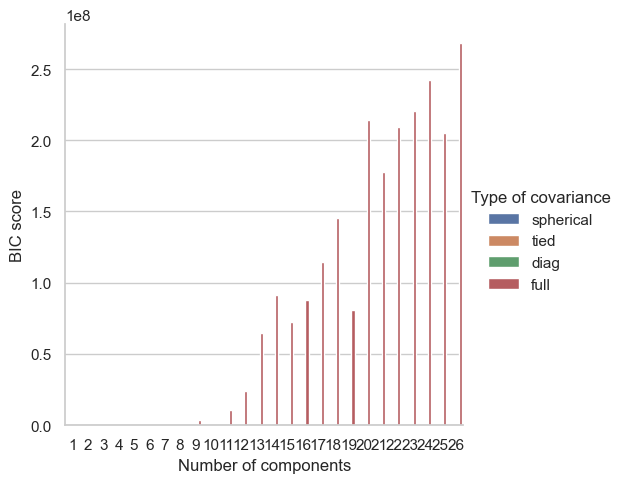

In [29]:
sns.catplot(
    data=grid_res,
    kind="bar",
    x="Number of components",
    y="BIC score",
    hue="Type of covariance",
)
plt.show()

Drop "full" to better visualize

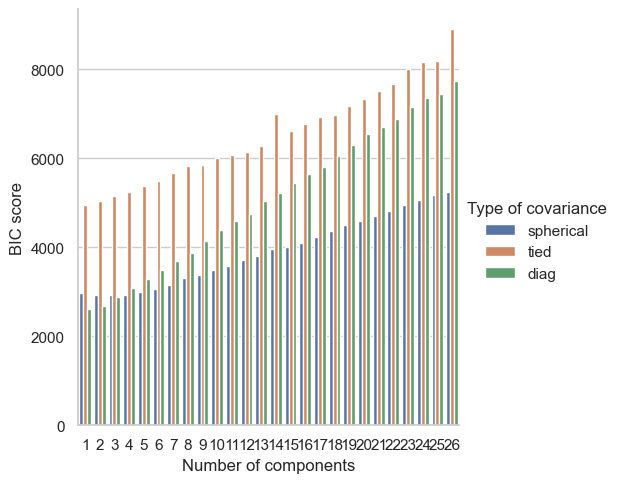

In [30]:
sns.catplot(
    data=grid_res[grid_res["Type of covariance"] != "full"],
    kind="bar",
    x="Number of components",
    y="BIC score",
    hue="Type of covariance",
)
plt.show()

PCA with 2 components is chosen for visualization purposes. Could also do 3 and make a 3d plot.

In [31]:
gmm = GaussianMixture(n_components=2, covariance_type="diag")
gmm_res = gmm.fit_predict(final_pca_25)
final_pca_25["cluster"] = gmm_res

X_LABEL = "PCA1 (~Human Development)"
Y_LABEL = "PCA2 (~Trade)"

In [32]:
final_clusters_countries = final_pca_25.merge(
    sustain_w_regions.drop_duplicates(subset="Country Code", keep="last").reset_index(),
    how='outer',
    left_index=True,
    right_index=True
)

In [33]:
final_clusters_countries["cluster"].unique()

array([0, 1], dtype=int64)

In [127]:
pd.set_option("display.max_rows", None)

In [132]:
final_clusters_countries[final_clusters_countries["cluster"] == 0][
    ["Country Name", "sub-region"]
]

,Country Name,sub-region
0,Aruba,Latin America and the Caribbean
1,Angola,Sub-Saharan Africa
3,United Arab Emirates,Western Asia
4,Argentina,Latin America and the Caribbean
5,Armenia,Western Asia
6,Antigua and Barbuda,Latin America and the Caribbean
7,Australia,Australia and New Zealand
8,Austria,Western Europe
9,Azerbaijan,Western Asia
10,Burundi,Sub-Saharan Africa


In [133]:
final_clusters_countries[
    (final_clusters_countries["cluster"] == 0)
    & (final_clusters_countries["sub-region"] == "Western Europe")
][["Country Name", "sub-region"]]

,Country Name,sub-region
8,Austria,Western Europe
11,Belgium,Western Europe
29,Switzerland,Western Europe
43,Germany,Western Europe
56,France,Western Europe
119,Netherlands,Western Europe


In [134]:
final_clusters_countries[
    (final_clusters_countries["cluster"] == 0)
    & (final_clusters_countries["sub-region"] == "Eastern Europe")
][["Country Name", "sub-region"]]

,Country Name,sub-region
15,Bulgaria,Eastern Europe
19,Belarus,Eastern Europe
42,Czech Republic,Eastern Europe
71,Hungary,Eastern Europe
100,Moldova,Eastern Europe
128,Poland,Eastern Europe
134,Romania,Eastern Europe
135,Russian Federation,Eastern Europe
145,Slovak Republic,Eastern Europe


In [138]:
final_clusters_countries[
    (final_clusters_countries["cluster"] == 0)
    & (final_clusters_countries["sub-region"] == "Eastern Asia")
][["Country Name", "sub-region"]]

,Country Name,sub-region
67,"Hong Kong SAR, China",Eastern Asia
109,Mongolia,Eastern Asia


In [139]:
final_clusters_countries[
    (final_clusters_countries["cluster"] == 1)
    & (final_clusters_countries["sub-region"] == "Eastern Asia")
][["Country Name", "sub-region"]]

,Country Name,sub-region
31,China,Eastern Asia
82,Japan,Eastern Asia
87,"Korea, Rep.",Eastern Asia
98,"Macao SAR, China",Eastern Asia
129,"Korea, Dem. People's Rep.",Eastern Asia


In [142]:
final_clusters_countries[
    (final_clusters_countries["cluster"] == 0)
    & (final_clusters_countries["sub-region"] == "Southern Europe")
][["Country Name", "sub-region"]]

,Country Name,sub-region
18,Bosnia and Herzegovina,Southern Europe
64,Greece,Southern Europe
69,Croatia,Southern Europe
79,Italy,Southern Europe
104,North Macedonia,Southern Europe
106,Malta,Southern Europe
108,Montenegro,Southern Europe
130,Portugal,Southern Europe
143,Serbia,Southern Europe
146,Slovenia,Southern Europe


In [143]:
final_clusters_countries[
    (final_clusters_countries["cluster"] == 1)
    & (final_clusters_countries["sub-region"] == "Southern Europe")
][["Country Name", "sub-region"]]

,Country Name,sub-region
2,Albania,Southern Europe
51,Spain,Southern Europe


In [140]:
len(final_clusters_countries[
    (final_clusters_countries["cluster"] == 0)
])

121

In [141]:
len(final_clusters_countries[(final_clusters_countries["cluster"] == 1)])

52

In [122]:
final_clusters_countries[final_clusters_countries["cluster"] == 1][["Country Name", 'sub-region']]

,Country Name,sub-region
2,Albania,Southern Europe
22,Brazil,Latin America and the Caribbean
26,Botswana,Sub-Saharan Africa
31,China,Eastern Asia
32,Cote d'Ivoire,Sub-Saharan Africa
34,"Congo, Dem. Rep.",Sub-Saharan Africa
37,Comoros,Sub-Saharan Africa
38,Cabo Verde,Sub-Saharan Africa
51,Spain,Southern Europe
52,Estonia,Northern Europe


Plot 2d and 3d for visualization purposes

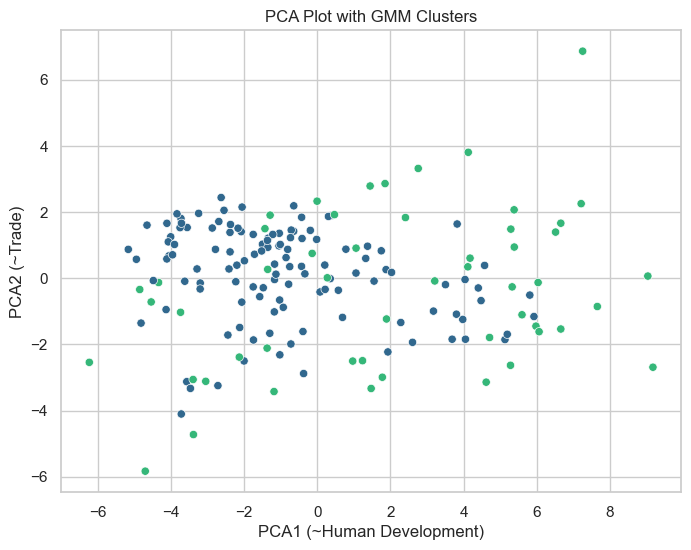

In [80]:
X_LABEL = "PCA1 (~Human Development)"
Y_LABEL = "PCA2 (~Trade)"


plt.figure(figsize=(8, 6))
scatterplot = sns.scatterplot(
    x=0, y=1, hue="cluster", data=final_clusters_countries, palette="viridis"
)

scatterplot.set_title("PCA Plot with GMM Clusters")

plt.legend(title="Cluster")

plt.xlabel(X_LABEL)
plt.ylabel(Y_LABEL)

plt.legend([],[], frameon=False)
plt.show()

In [40]:
regions = (
    pd.read_csv("../data/sustainability_w_regions.csv")[
        ["Country Code", "sub-region", "region"]
    ]
    .drop_duplicates(subset="Country Code", keep="last")
    .drop(columns="Country Code")
)

In [42]:
final_clusters_countries = final_clusters_countries.merge(
    regions.reset_index(), how="outer", left_index=True, right_index=True
)

In [115]:
region_markers = {
    "Americas": "o",
    "Africa": "v",
    "Europe": "s",
    "Asia": "p",
    "Oceania": "*",
}

sub_markers = {
    "Latin America and the Caribbean": "D",
    "Sub-Saharan Africa": "P",
    "Southern Europe": "o",
    "Western Asia": "<",
    "Australia and New Zealand": "s",
    "Southern Asia": "v",
    "Eastern Europe": "h",
    "South-eastern Asia": ">",
    "Northern America": "p",
    "Eastern Asia": "^",
    "Northern Europe": "d",
    "Northern Africa": "*",
    "Melanesia": ".",
    "Central Asia": "8",
    "Polynesia": ".",
    "Western Europe": "X",
}

In [116]:
final_clusters_countries["region_markers"] = final_clusters_countries["region"].apply(
    lambda x: region_markers[x]
)
final_clusters_countries["sub_markers"] = final_clusters_countries["sub-region"].apply(
    lambda x: sub_markers[x]
)

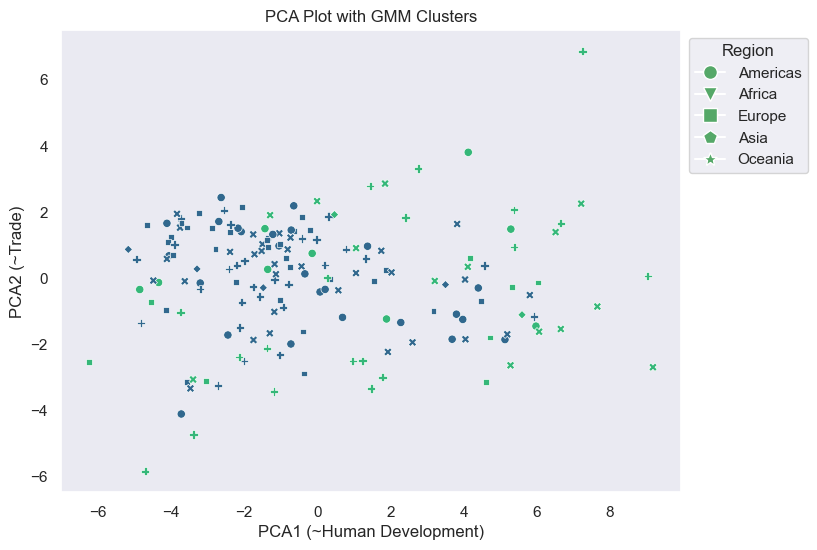

In [117]:
# Set figure size
plt.figure(figsize=(8, 6))

# Create the scatter plot
scatterplot = sns.scatterplot(
    data=final_clusters_countries,
    x=0,
    y=1, 
    hue="cluster",
    style="region_markers",
    palette="viridis",
)

scatterplot.set_title("PCA Plot with GMM Clusters")
plt.xlabel(X_LABEL)
plt.ylabel(Y_LABEL)

regions = final_clusters_countries["region"].unique()
markers = final_clusters_countries.groupby("region")["region_markers"].first()

legend_handles = [
    plt.Line2D(
        [0],
        [0],
        marker=markers[region],
        color="w",
        label=region,
        markerfacecolor="g",
        markersize=10,
    )
    for region in regions
]

plt.legend(
    handles=legend_handles, title="Region", loc="upper left", bbox_to_anchor=(1, 1)
)

plt.show()

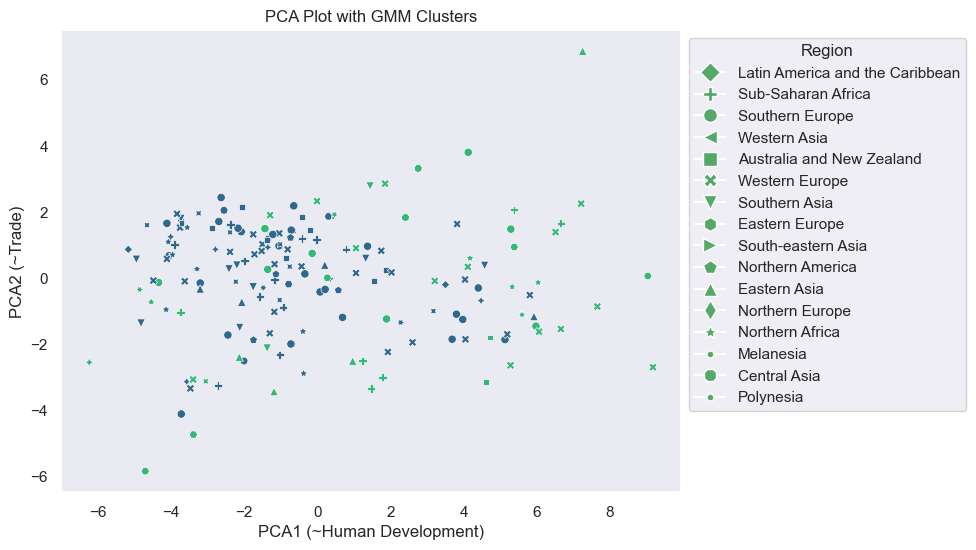

In [118]:
# Set figure size
plt.figure(figsize=(8, 6))

# Create the scatter plot
scatterplot = sns.scatterplot(
    data=final_clusters_countries,
    x=0,
    y=1,
    hue="cluster",
    style="sub_markers",
    palette="viridis",
)

scatterplot.set_title("PCA Plot with GMM Clusters")
plt.xlabel(X_LABEL)
plt.ylabel(Y_LABEL)

regions = final_clusters_countries["sub-region"].unique()
markers = final_clusters_countries.groupby("sub-region")["sub_markers"].first()

legend_handles = [
    plt.Line2D(
        [0],
        [0],
        marker=markers[region],
        color="w",
        label=region,
        markerfacecolor="g",
        markersize=10,
    )
    for region in regions
]

plt.legend(
    handles=legend_handles, title="Region", loc="upper left", bbox_to_anchor=(1, 1)
)

plt.show()

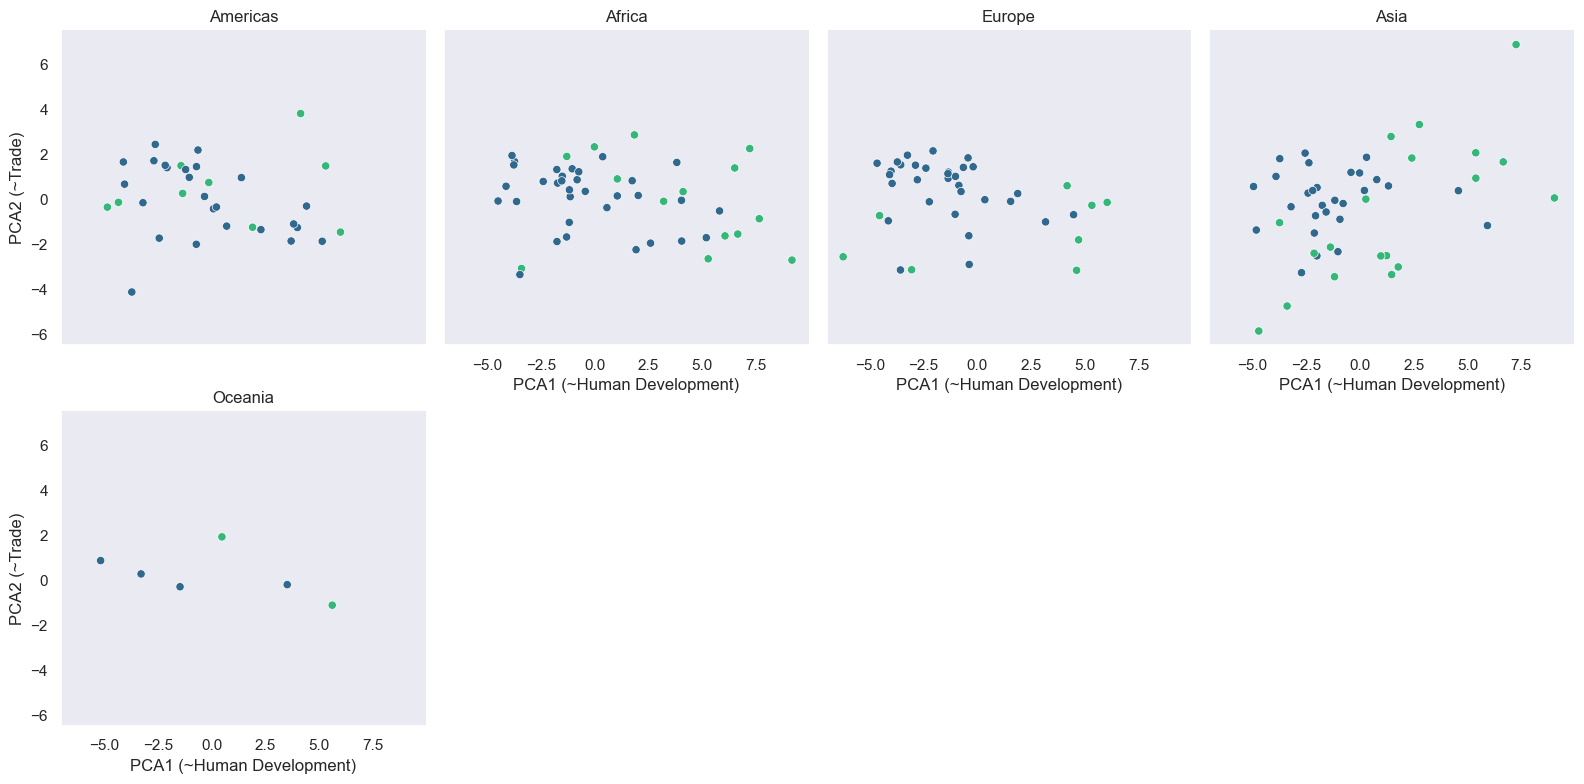

In [113]:
sns.set_style("dark")
g = sns.FacetGrid(final_clusters_countries, col="region", col_wrap=4, height=4)

g = g.map_dataframe(sns.scatterplot, 0, 1, hue="cluster", palette="viridis")

g.set_titles("{col_name}")
g.set_axis_labels(X_LABEL, Y_LABEL)
plt.show()

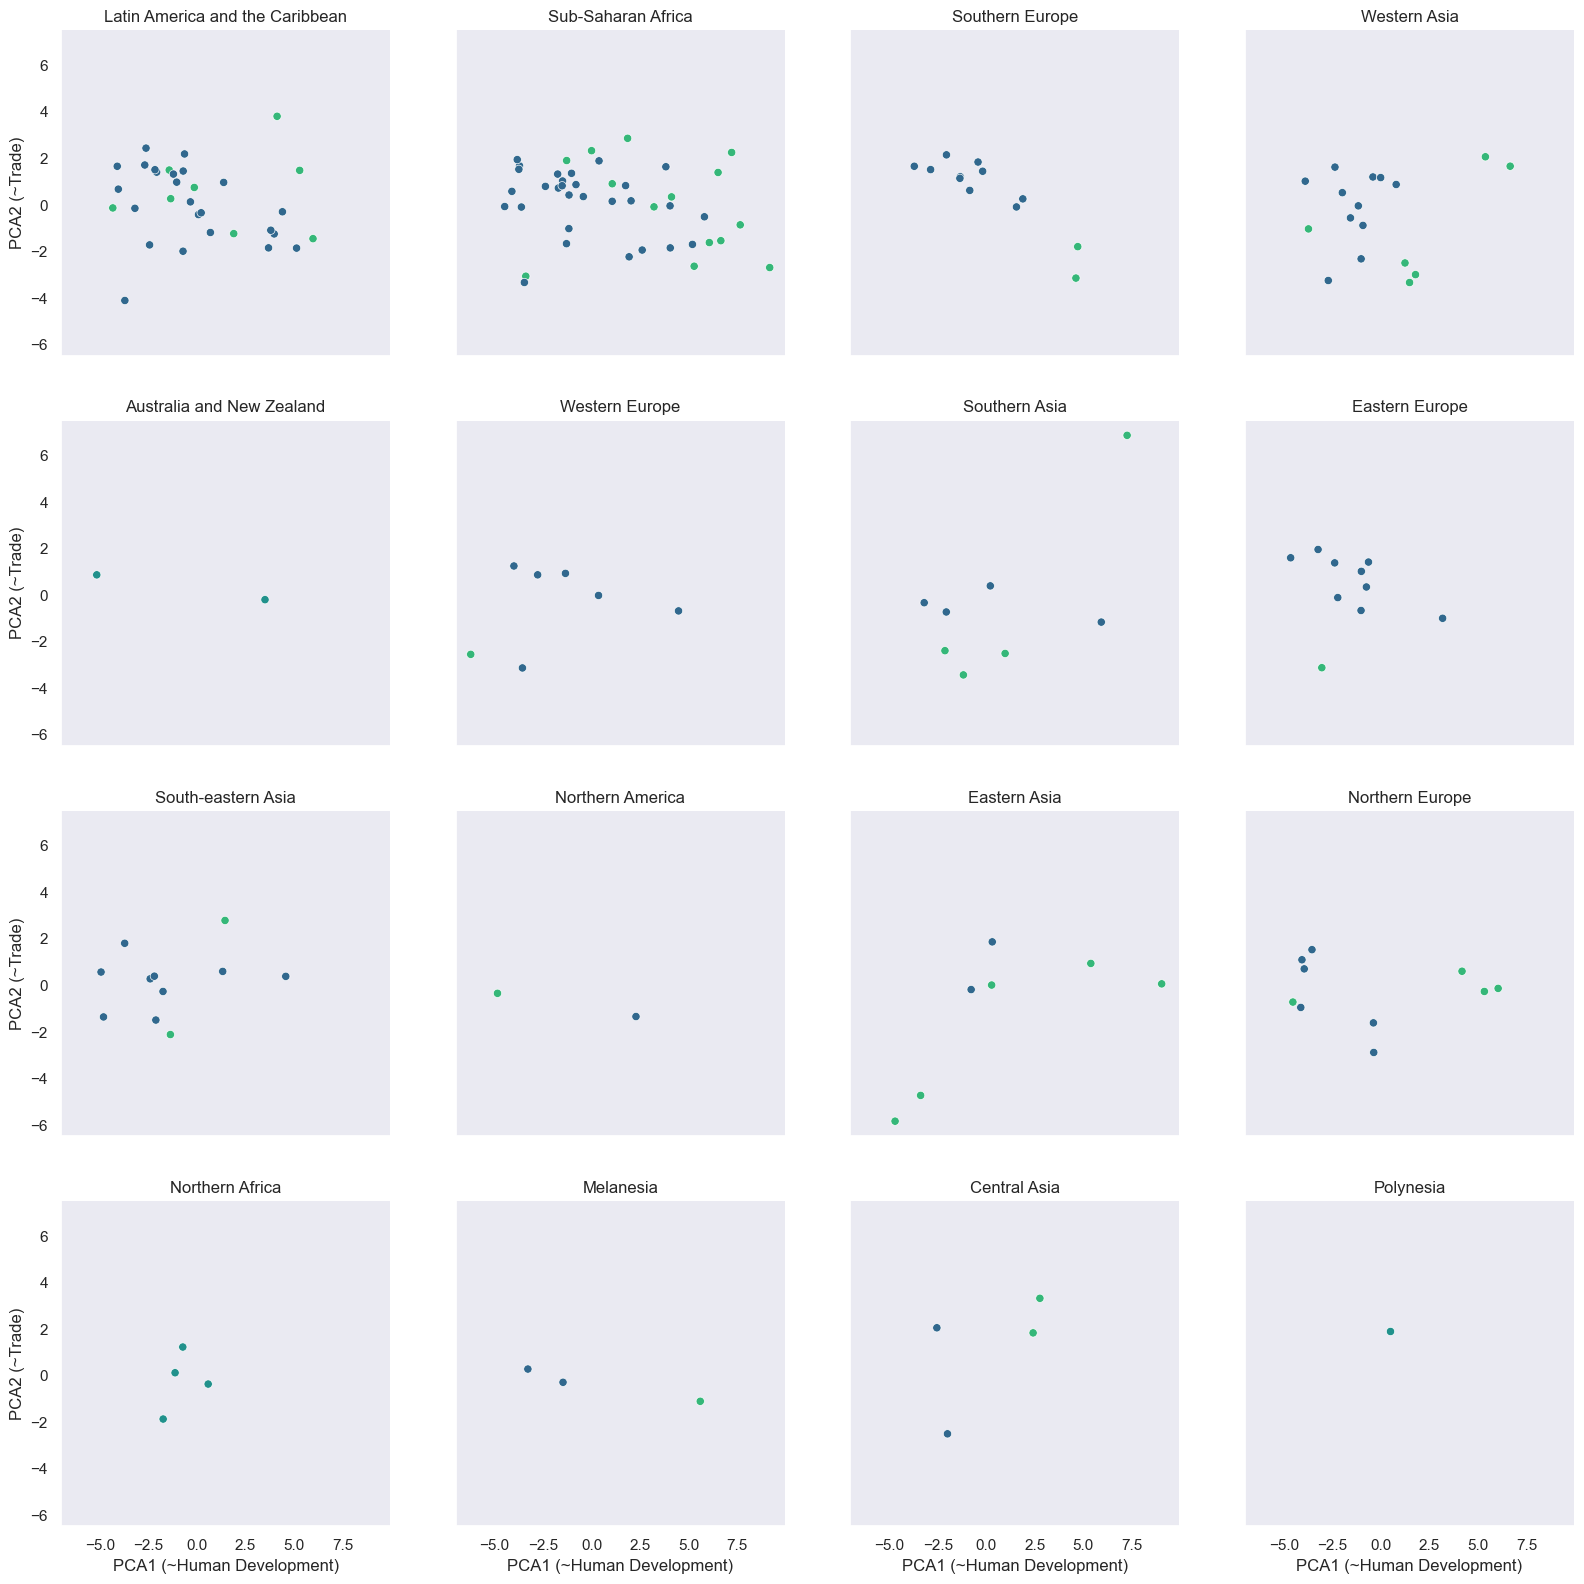

In [114]:
g = sns.FacetGrid(final_clusters_countries, col="sub-region", col_wrap=4, height=4)

g = g.map_dataframe(sns.scatterplot, 0, 1, hue="cluster", palette="viridis")

g.set_titles("{col_name}")
g.set_axis_labels(X_LABEL, Y_LABEL)
g.fig.subplots_adjust(wspace=0.2, hspace=0.2)
plt.show()

## Silhouette

In [121]:
from sklearn import metrics

print(
    f"Silhouette Coefficient: {metrics.silhouette_score(final_clusters_countries[[0,1]], final_clusters_countries['cluster']):.3f}"
)

Silhouette Coefficient: 0.219


## FINDINGS
GMM clustering does not appear to be highly effective for this data. The BIC score indicated that the best number of clusters is 1, however, the score for 2 clusters was not significantly worse. We chose to use two clusters to understand, through analysis and visualization, how GMM was separating countries.

Most regions have a balanced mix of nations in regards to their development, economic, and sustainability metrics. Most notably, there appears to be no significant inter-regional trend- e.g. regions that are traditionally considered highly developed (Western Europe for instance) have many countries in the "Blue" cluster, but so do regions which are traditionally considered developing (Sub-Saharan Africa for instance). Such findings indicate that there is a balance between economic development and other sustainability metrics, such as emissions per capita. Such traditionally under-developed countries have much lower environmental impact per capita, and as a result, are grouped with traditionally developed countries due to their outsized performance on these metrics.

For intra-regional analysis, some notable outliers within their regions are:
- Ukraine (Eastern Europe): Ukraine has historically been an agrarian economy. Such economies are often less developed and produce fewer emissions. However, the region as a whole is generally considered a mix of more and less developed nations, so it is notable that Ukraine is such an outlier.
- Hong Kong and Mongolia (Eastern Asia): Hong Kong, due to its size and lack of many natural resources, is necessarily an incredibly efficient (due to population density) nation with few industrial emissions. Mongolia is the least developed nation in the region and is somewhat agrarian.
- Spain and Albania (Southern Europe): Spain is extremely well developed in terms of human development, but suffers on a few economic measures like GDP per capita. However, due to their robust social services and public transit, it is not surprising that they perform well on other sustainability metrics. Albania is generally considered a developing European country, and likely performs low on economic measures, but well on emissions and other sustainability metrics as a result.

---

In [ ]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df_uncorr)

pca_df = pd.DataFrame(data=pca_result, columns=["PCA1", "PCA2", "PCA3"])
pca_df["cluster"] = gmm_res

In [ ]:
plt.figure(figsize=(8, 6))
px.scatter_3d(pca_df, x='PCA1', y='PCA2', z='PCA3', color='cluster')

<Figure size 800x600 with 0 Axes>